In [1]:
import pandas as pd
import numpy as np
import datetime as dt

# set options
pd.options.display.max_colwidth = 50
pd.set_option('display.max_colwidth', -1) 
pd.options.mode.chained_assignment = None  # default='warn'

## Loading data

In [2]:
food_reviews = pd.read_csv('../input/Reviews.csv', encoding="ISO-8859-1")

In [3]:
food_reviews.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [ ]:
# removing last row since null
food_reviews = food_reviews.iloc[0:len(food_reviews) - 1,]

In [4]:
#food_reviews.drop(columns=['Id'],inplace = True)

## Pre-processing data

* renaming columns
* checking datatype
* dealing with null values - impute for summary, removal of rest
* reindexing of data
* conversion of timestamp to date
* features - creation of helfulness_score, extended review
* removal of neutral reviews - with rating 3
* classificaton of positive and negative sentiment into 0 and 1

#### Renaming columns

In [5]:
# rename columns
#food_reviews.columns = [each.split("/")[1] for each in food_reviews.columns]
#food_reviews.columns = ['productid', 'userid', 'username', 'helpful_upvotes','helpful_responses','rating','time','summary','text']
food_reviews.columns = ['productid', 'userid', 'username', 'helpfulness','rating','time','summary','text']

food_reviews.head()

,productid,userid,username,helpful_upvotes,helpful_responses,rating,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


#### Check datatypes

In [6]:
food_reviews.dtypes

productid            object
userid               object
username             object
helpful_upvotes      int64 
helpful_responses    int64 
rating               int64 
time                 int64 
summary              object
text                 object
dtype: object

#### Dealing with null values - imputation / dropping

In [7]:
# check all null records (any one column)
food_reviews[food_reviews.isnull().values]

,productid,userid,username,helpful_upvotes,helpful_responses,rating,time,summary,text
25509,B000LKZB4Y,A36BVYD0NT7Z0F,NaN,0,0,5,1314576000,These are the best mints and no aspartame or BHT,I was so shocked to find out that almost all gums have BHT. I went to the health food store and got gum with Xylitol but I didn't like the taste. B Fresh was the only one with Xylitol that didn't taste like aspartame. I saw Newmans Own Organic Mints and was happy to see no aspartame or BHT and they are really good. I hope the company starts making gum. The only problem is the mints are made in Mexico. What is the matter Americans can't make mints?
33958,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either."
38874,B000AYDGZ2,A36BVYD0NT7Z0F,NaN,2,3,1,1278374400,doesn't anyone care that they are putting BHT into their bodies?,I called Kellogg's to see why Special K red berries has the natural preservative but Special K blueberry has the killer BHT. The women who answered wasn't helpful and didn't know why. She also seemed annoyed with my question. I won't even give my dog food with BHT why would I feed my family a cereal with BHT. Why don't these company use the more natural and safer preservative like tocoperol etc?
40548,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either."
49800,B000CRHQN0,A2LYFY32LXQDON,NaN,0,0,2,1282608000,They were melted and the chocolate had turned white,"We love these bars but i won't order them shipped from anywhere anymore. They came melted, white, and didn't taste as good as they do when they are fresh."
67077,B0006348H2,A2P0P67Y55SNOX,NaN,1,1,5,1314662400,Wheatgrass,"Kitty seems to like this sprinkled on her food...Glad I bought 2, because I forgot to water one for a few days... Brown grass doesn't work..."
101106,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either."
102979,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either."
106550,B001EQ5DG0,A1P500QXEG3IUZ,NaN,0,0,5,1326758400,Finally!,"You cannot find this in the stores anymore, it's impossible to find. The price sometimes can be ridiculous ranging up above $40 (REALLY!). I orderd this on the subscribe and save under $18, but if the price increased, will discountinue it."
117515,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,"I only used two maybe three tea bags and got pregnant - can not drink during pregnancy. Not a bad taste, but I'm not a big tea fan either."


In [8]:
# Dropping Summary and text columns have missing values. Dropping those rows which have both of them missing.
food_reviews = food_reviews[food_reviews['summary'].notnull() | food_reviews['text'].notnull()]
# Where NA in summary, replace with None
food_reviews['summary'] = food_reviews['summary'].replace(np.nan,'None', regex=True)

In [9]:
# check remaining null values
food_reviews.isna().sum()

productid            0 
userid               0 
username             16
helpful_upvotes      0 
helpful_responses    0 
rating               0 
time                 0 
summary              0 
text                 0 
dtype: int64

In [10]:
# drop remaining null values
food_reviews.dropna(inplace = True)
food_reviews.shape

(568438, 9)

#### Reindexing of data

In [11]:
# since all null records are gone, reindex
food_reviews.index = range(food_reviews.shape[0])

#### Extracting time,month,year

In [12]:
food_reviews['time'] = pd.to_datetime(food_reviews['time'], unit='s')
food_reviews['year'] = food_reviews['time'].dt.year
food_reviews['month'] = food_reviews['time'].dt.month
food_reviews.head()

,productid,userid,username,helpful_upvotes,helpful_responses,rating,time,summary,text,year,month
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,2011,4
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",2012,9
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",2008,8
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,2011,6
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",2012,10


#### Extracting helpfulness score

In [13]:
food_reviews.loc[:,'helpful_upvotes'] = food_reviews.helpfulness.apply(lambda x: float(x.split("/")[0]))
food_reviews.loc[:,'helpful_responses'] = food_reviews.helpfulness.apply(lambda x: float(x.split("/")[1]))

In [14]:
# drop the 2 rows where upvotes > responses since it doesn't make sense
food_reviews = food_reviews[~(food_reviews.helpful_upvotes > food_reviews.helpful_responses)]

In [15]:
food_reviews['helpfulness_score']  = food_reviews.helpful_upvotes / food_reviews.helpful_responses 

In [16]:
food_reviews.helpfulness_score[food_reviews['helpful_responses'] == 0] = -1
food_reviews.head()

,productid,userid,username,helpful_upvotes,helpful_responses,rating,time,summary,text,year,month,helpfulness_score
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,2011,4,1.0
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",2012,9,-1.0
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.",2008,8,1.0
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,2011,6,1.0
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",2012,10,-1.0


#### Create extended review text

In [17]:
# create extended text column
food_reviews['text_ext'] = food_reviews['summary'] + ' ' + food_reviews['text']

In [18]:
food_reviews_eda = food_reviews.copy() # store in another df for eda below which requires rating 3

#### Remove of neutral reviews

In [19]:
food_reviews = food_reviews[~(food_reviews['rating'] == 3.0)]
food_reviews['rating'].value_counts()

5    363110
4    80654 
1    52264 
2    29768 
Name: rating, dtype: int64

#### Classification of positive and negative reviews                        

Giving scores of 4 and above a 1 and a 0 to 2 and below

In [20]:
food_reviews['sentiment'] = food_reviews['rating'].apply(lambda x: 0 if x == 1 or x == 2 else 1)

In [21]:
# reorder columns
#food_reviews.drop(columns=['helpfulness'])
columnsTitles = ['productid', 'userid', 'username', 'time' ,'year','month','helpful_upvotes',
                 'helpful_responses','helpfulness_score','rating','sentiment','text_ext','summary','text']
food_reviews = food_reviews.reindex(columns=columnsTitles)

#### Final dataframe

In [22]:
food_reviews.head(5)

,productid,userid,username,time,year,month,helpful_upvotes,helpful_responses,helpfulness_score,rating,sentiment,text_ext,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,2011-04-27,2011,4,1,1,1.0,5,1,Good Quality Dog Food I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,2012-09-07,2012,9,0,0,-1.0,1,0,"Not as Advertised Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",2008-08-18,2008,8,1,1,1.0,4,1,"""Delight"" says it all This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.","""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,B000UA0QIQ,A395BORC6FGVXV,Karl,2011-06-13,2011,6,3,3,1.0,2,0,Cough Medicine If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",2012-10-21,2012,10,0,0,-1.0,5,1,"Great taffy Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


## Exploratory Data Analysis

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import squarify 
import matplotlib
import pylab
import matplotlib.dates as mdates

In [24]:
print (len(food_reviews_eda.productid.unique()), len(food_reviews_eda.userid.unique()))

74258 256050


In [25]:
food_reviews_eda.describe()

# Total 525k records or reviews of 74k unique products by 256k unique users.
# Data ranges from 1999 to 2012 , granularity - daily and user/product level
# Data is skewed towards positive sentiment

,helpful_upvotes,helpful_responses,rating,year,month,helpfulness_score
count,568436.000000,568436.000000,568436.000000,568436.000000,568436.000000,568436.000000
mean,1.743832,2.228830,4.183208,2010.582857,6.460207,-0.067197
std,7.636614,8.289827,1.310421,1.531867,3.406349,0.922166
min,0.000000,0.000000,1.000000,1999.000000,1.000000,-1.000000
25%,0.000000,0.000000,4.000000,2010.000000,3.000000,-1.000000
50%,0.000000,1.000000,5.000000,2011.000000,7.000000,0.000000
75%,2.000000,2.000000,5.000000,2012.000000,9.000000,1.000000
max,866.000000,923.000000,5.000000,2012.000000,12.000000,1.000000


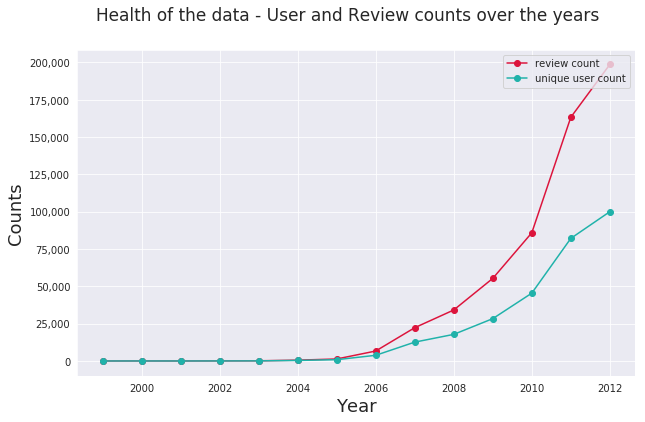

In [26]:
# Health of the data
df1 = food_reviews_eda.groupby(['year']).size().reset_index(name='reviewcount')
df1 = df1.sort_values(by='year')

df2 = food_reviews_eda.groupby(['year']).userid.nunique().reset_index(name='usercount')
df2 = df2.sort_values(by='year')

# Plotting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.plot('year', 'reviewcount', label = 'review count', data=df1, marker='o', color='crimson')
plt.plot('year', 'usercount', label = 'unique user count', data=df2, marker='o', color='lightseagreen')

# Format plots
fig.suptitle('Health of the data - User and Review counts over the years', fontsize=17)
plt.xlabel('Year', fontsize=18)
plt.ylabel('Counts', fontsize=18)
pylab.legend(loc='upper right')
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

# Display
plt.show()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


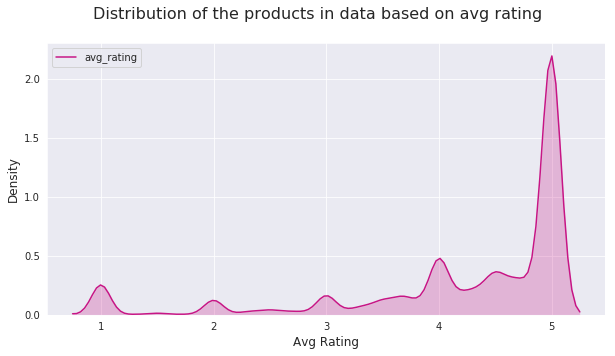

In [27]:
# Data grouped Product wise
df1 = food_reviews.groupby(['productid']).rating.mean().reset_index(name='avg_rating')
df1 = df1.sort_values(by='productid')

df2 = food_reviews.groupby(['productid']).size().reset_index(name='review_count')
df2 = df2.sort_values(by='productid')

df3 = []
df3 = pd.DataFrame(df3)
df3['productid'] = df1['productid']
df3['avg_rating'] = df1['avg_rating']
df3['review_count'] = df2['review_count']

# Distribution of products in data based on rating and review counts
# Plotting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
sns.kdeplot(df3['avg_rating'], shade=True, color="mediumvioletred")

# Format plots
fig.suptitle('Distribution of the products in data based on avg rating', fontsize=16)
plt.xlabel('Avg Rating', fontsize=12)
plt.ylabel('Density', fontsize=12)

# Display
plt.show()

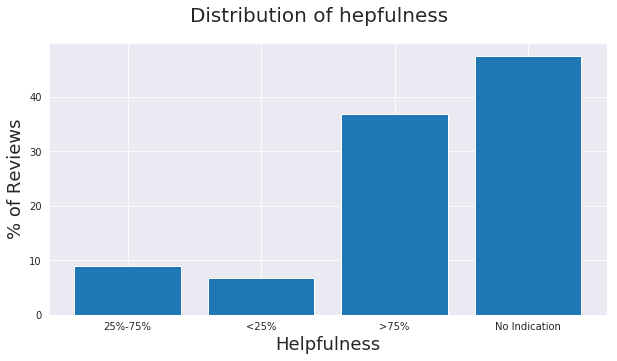

'\n Helpful reviews had more than 75% of voters find the review helpful,\n unhelpful reviews had less than 25% of voters find the review helpful, and an intermediate group of 25-75% helpfulness. \n This choice of division seemed to not have a larger impact on results; we will henceforth use this terminology to describe \n the helpfulness of reviews. Among reviews that are voted on, helpful reviews are the most common.\n '

In [28]:
# Impact of helpfulness
df1 = food_reviews_eda.copy()
df1['hpercent'] = ""
df1.hpercent[df1['helpfulness_score'] > 0.25 ] = "> 75%"
df1.hpercent[df1['helpfulness_score'] < 0.75 ] = "25%-75%"
df1.hpercent[df1['helpfulness_score'] < 0.25 ] = "< 25%"
df1.hpercent[df1['helpfulness_score'] == -1 ] = "No Indication"
df2 = df1.groupby(['hpercent']).size().reset_index(name = 'hpercent2')
df2['prop'] = df2['hpercent2']*100/len(df1)

height = df2['prop']
bars = ('25%-75%', '<25%', '>75%', 'No Indication')
y_pos = np.arange(len(bars))

 # Plotting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

# Create bars
plt.bar(y_pos, height)
# Create names on the x-axis
plt.xticks(y_pos, bars)

# Format plots
fig.suptitle('Distribution of helpfulness', fontsize=20)
plt.xlabel('Helpfulness', fontsize=18)
plt.ylabel('% of Reviews', fontsize=18)

# Display
plt.show()

"""
 Helpful reviews had more than 75% of voters find the review helpful,
 unhelpful reviews had less than 25% of voters find the review helpful, and an intermediate group of 25-75% helpfulness. 
 This choice of division seemed to not have a larger impact on results; we will henceforth use this terminology to describe 
 the helpfulness of reviews. Among reviews that are voted on, helpful reviews are the most common.
 """

<Figure size 720x360 with 0 Axes>

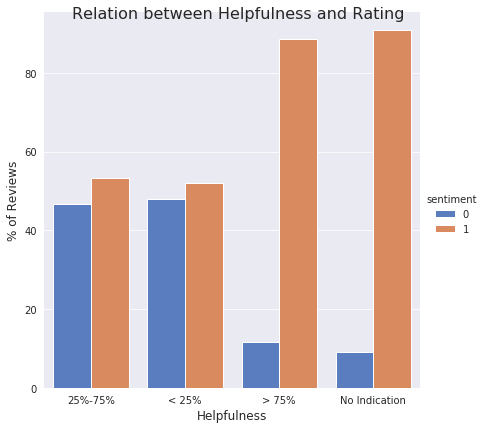

In [30]:
# Impact of helpfulness - further on rating
df1 = food_reviews.copy()
df1['hpercent'] = ""
df1.hpercent[df1['helpfulness_score'] > 0.25 ] = "> 75%"
df1.hpercent[df1['helpfulness_score'] < 0.75 ] = "25%-75%"
df1.hpercent[df1['helpfulness_score'] < 0.25 ] = "< 25%"
df1.hpercent[df1['helpfulness_score'] == -1 ] = "No Indication"
df2 = df1.groupby(['hpercent','sentiment']).size()
df3 = df2.groupby(level=0).apply(lambda x: x/x.sum() * 100).reset_index()
df3.columns = ['hpercent','sentiment','p']
df3 = pd.DataFrame(df3)

 # Plotting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))

# Draw a nested barplot to show survival for class and sex
g = sns.catplot(x="hpercent", y="p", hue="sentiment", data=df3,height=6, kind="bar", palette="muted")
g.despine(left=True)

# Format plots
g.fig.suptitle('Relation between Helpfulness and Rating', fontsize=16)
plt.xlabel('Helpfulness', fontsize=12)
plt.ylabel('% of Reviews', fontsize=12)

# Display
plt.show()

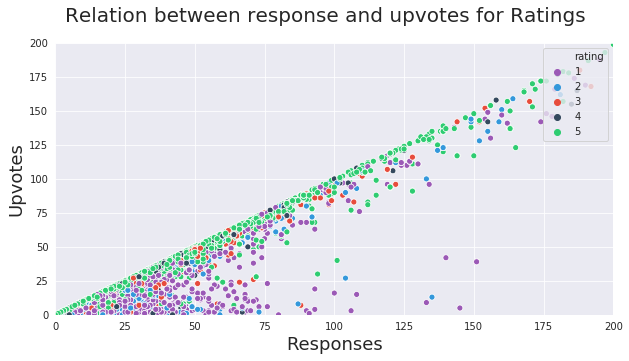

'\nhigher rated products are likely to get upvotes equal to responses, meaning that other users generally find \nhigher rated reviews of products very helpful, infact more helpful than negative reviews \n'

In [31]:
# relation between upvotes and response and rating
df1 = food_reviews_eda.copy()

flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71"]

# Plotting
sns.set_style("darkgrid")
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax = sns.scatterplot(x="helpful_responses", y="helpful_upvotes", hue="rating",palette=sns.color_palette(flatui),data=df1)

# Format plots
fig.suptitle('Relation between response and upvotes for Ratings', fontsize=20)
plt.xlabel('Responses', fontsize=18)
plt.ylabel('Upvotes', fontsize=18)
pylab.legend(loc='upper right')
plt.ylim(0, 200)
plt.xlim(0, 200)

# Display
plt.show()

'''
higher rated products are likely to get upvotes equal to responses, meaning that other users generally find 
higher rated reviews of products very helpful, infact more helpful than negative reviews 
'''

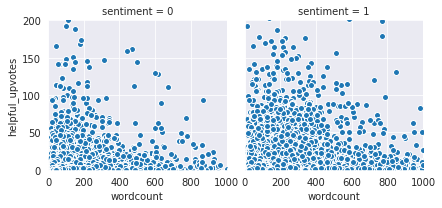

In [32]:
# relation between review length and upvotes
df1 = food_reviews.copy()
df1['wordcount'] = df1['text'].str.split().str.len()
df1.head()

# scatter between wordcount vs helpvars
# Plotting
flatui = ["#9b59b6", "#3498db"]

sns.set_style("darkgrid")
g = sns.FacetGrid(df1, col="sentiment")
g = (g.map(plt.scatter, "wordcount", "helpful_upvotes", edgecolor="w").add_legend())

# Format plots
fig.suptitle('Relation between review length and help', fontsize=20)
plt.ylim(0, 200)
plt.xlim(0, 1000)

# Display
plt.show()

In [33]:
# wordcloud for positive sentiment
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import Word2Vec

from wordcloud import WordCloud
from collections import defaultdict

In [34]:
def get_common_surface_form(original_corpus, stemmer):
    counts = defaultdict(lambda : defaultdict(int))
    surface_forms = {}

    for document in original_corpus:
        for token in document:
            stemmed = stemmer.stem(token)
            counts[stemmed][token] += 1

    for stemmed, originals in counts.items():
        surface_forms[stemmed] = max(originals, 
                                     key=lambda i: originals[i])

    return surface_forms

stemmer = PorterStemmer() # Stemmer for reducing terms to root form 
stemmed_corpus = []       # For storing the stemmed tokens 
original_corpus = []      # For storing the non-stemmed tokens

df1 = food_reviews[food_reviews.sentiment == 1]
contents = df1.text
tokens = contents.str.lower().apply(lambda x: word_tokenize(x))
stemmed = tokens.apply(lambda x: [stemmer.stem(token) for token in x])

dictionary = Dictionary(stemmed) # Build the dictionary
# Get the surface form for each stemmed word
counts = get_common_surface_form(tokens, stemmer)
# Convert to vector corpus
vectors = [dictionary.doc2bow(text) for text in stemmed]
# Train TF-IDF model
tfidf = TfidfModel(vectors)
# Get TF-IDF weights
weights = tfidf[vectors[0]]
# Replace term IDs with human consumable strings
weights = [(counts[dictionary[pair[0]]], pair[1]) for pair in weights]


AttributeError: 'WordListCorpusReader' object has no attribute 'add'

In [35]:

stopset = set(nltk.corpus.stopwords.words('english'))
stopset.add("br")
# Initialize the cloud
wc = WordCloud(
    background_color="white",
    max_words=2000,
    width=1024,
    height=720,
    stopwords=stopset
)

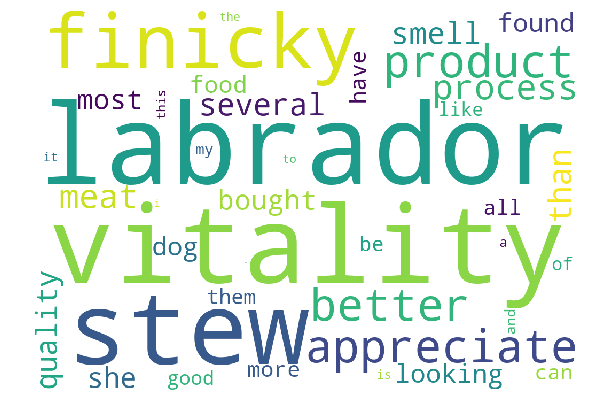

In [36]:
# Generate the cloud
weights = dict(weights)
wc.generate_from_frequencies(weights)

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 